# Notebook: MCMC SHAP

This notebook focuses on getting a confidence interval for shapley values.

makes use of https://github.com/slundberg/shap/blob/master/shap/explainers/_sampling.py

In [4]:
# import libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm


from sklearn.preprocessing import MinMaxScaler


from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
%matplotlib inline

%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
#tf.random.set_seed(42)
np.random.seed(42)

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#matplotlib.use('TkAgg')

# Potential Plots to Choose Cases

To get the potential we just integrate the equation of motion:

Therefore:

$E(t) = \frac{1}{2}\dot{x}^2 + \frac{1}{2}\alpha x^2 + \frac{1}{4} \beta x^4 = const.$

And we get a nice way to decide on which cases could be of interest.

<IPython.core.display.Javascript object>


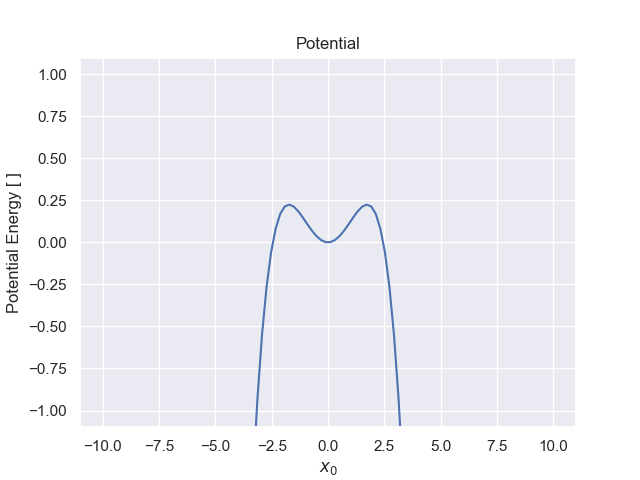

interactive(children=(FloatSlider(value=1.0, description='alpha', max=3.0, min=-1.0), FloatSlider(value=1.0, d…

In [5]:
x = np.linspace(-10,10,100)
v = 0
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(alpha = 1.0, beta = 1.0):
    line.set_ydata(0.5*v**2 + 0.5*alpha*x**2 +0.25*beta*x**4)
    fig.canvas.draw_idle()

ax.set_title(r"Potential")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"Potential Energy [ ]")
interact(update);

In [13]:
"""
Define Parameter Configuration to Model

    Parameters
    ----------
    alpha : float, linear stiffness
    beta  : float, non linearity in the restoring force
    gamma : float, amplitude of the periodic driving force
    delta : float, amount of damping
    omega : float, angular frequency of the periodic driving force
 """   



alpha = 0.3
beta = -0.1
gamma = 0.37
delta = 0.3
omega = 1.2

parameters = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'delta': delta, 'omega':omega}

suffix = "params_"+str(alpha)+"_"+str(beta)+"_"+str(gamma)+"_"+str(delta)+"_"+str(omega)

In [14]:
def eom(t, u, params = {}):
    """
        Duffing Oscillator Equation of Motion

        ddx + delta * dx + alpha * x + beta * x**3 = gamma * cos(omega * t)

        Input
        ----------
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Returns
        ----------
        [dx,ddx] : Tuple, Time derivatives of 
                    position and velocity at time t

    """
    x, dx = u[0], u[1]
    ddx = (gamma * np.cos(omega * t) - (delta * dx + alpha * x + beta * x**3))

    return [dx,ddx]

# Designing a Numerical Explainer

The first attempt at numerical explainability functions using a central finite differences method to approximate the gradient of the function. The reasoning behind this is that small fluctuations in important features have a greater impact than small fluctuations in less important features.

The second attempt uses a similar idea (the idea that we can look at the volumes that map onto eachother under the function that we are trying to explain).

$f: \mathbb{R}^k \rightarrow \mathbb{R}^d$

$f(\vec{x}) = \vec{y}$

So we define an area $A$ around the target variable $\vec{y}$ using a tolerance $\epsilon$:

$A = \mathcal{B}(\vec{y}, \epsilon)$

Where $\mathcal{B}(\vec{y}, \epsilon)$ is a ball centered on $\vec{y}$ with radius $\epsilon$.

This will become an ellipsoid with major axes $\vec{\delta}$ where the entries in $\vec{\delta}$ are dependent on the feature ranges and variances present in the input data.


Requires inverting f (not possible so either pseudoinverse or monte carlo sample from the intial distribution to see which points end up in the are around y):

$f^{-1}(\mathcal{B}_{\epsilon}( \underline{y} )) = \mathcal{B}'_{\underline{\delta}}(\underline{x})$

Where $\mathcal{B}'_{\underline{\delta}}(\underline{x})$ is the aforementioned ellipsoid.

In [15]:
class NumericExplainer():
    """
        Pretty Brute force numerical gradient calculation for
        explainability of a known function
    """
    def __init__(self, f, features, labels,  h=0.01):
        """
            Initialises with some configurations for the gradient calculation
            as well as the function being differentiated.
            
            Inputs
            --------
            f : function that takes a pandas.DataFrame and outputs a 2d np.array.
            features : list of features in the pd.DataFrame for which we are to 
                differentiate f.
            labels : list of features in the np.array.
        """
        self.f = f
        self.features = features
        self.labels = labels
        self.h = h
        
    def gradient(self, X_val, feature):
        """
            Numerical Gradient Calculation by way of a CFD method.
            Inputs
            --------
            X_val : pandas.DataFrame with columns: features and values at
                which we want to take the numerical gradient.
            feature : feature by which we want to differentiate.
        """
        X_prime_plus = X_val.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + self.h
        X_prime_minus = X_val.copy()
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - self.h
        
        grad = (self.f(X_prime_plus) - self.f(X_prime_minus))/(2*self.h)
        
        return grad
    def feature_att(self, X):
        """
            Calculates the Gradients for all Entries in X, for each
            feature and label combination.
            
            Inputs
            --------
            X : pandas.DataFrame with columns:features and values at
                which we want to differentiate.
            Returns
            --------
            self.__atts : [np.array[...],np.array[...]] of gradients at
                each of the input points. Calculated for each label and stacked.
        """
        first_run = True
        for i,__label in enumerate(self.labels):
            grads = self.gradient(X, self.features[0])[:,i]
            for __feat in self.features[1:]:
                grads = np.vstack((grads,self.gradient(X, __feat)[:,i]))
            normalised_grads = np.abs(grads)/np.sum(np.abs(grads),axis=0)
            if first_run:
                self.__atts = grads.transpose()
                self.__normalised = normalised_grads.transpose()
                first_run = False
            else:
                self.__atts = [self.__atts, grads.transpose()]
                self.__normalised = [self.__normalised, normalised_grads.transpose()]
                        
        return self.__atts#, self.__normalised
    

"""
def true_inverse(y):
    if type(X) == pd.core.frame.DataFrame:
        X = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X)[0], 2))
    for i in range(0,np.shape(X)[0]):
        t_range = np.linspace(0, X['t'].iloc[i], 100, endpoint=True)
        y[i,:] = odeint(eom, [X['x0'].iloc[i], X['v0'].iloc[i]], t_range)[-1]
    return y
class AreaExplainer():
    """

    """
    def __init__(self, function, inverse_function, area_tolerance = 0.1, num_area = 50):
        self.function = function
        self.inverse = inverse_function
        
        # extract feature ranges and variances
        # (by looking at )
        
        # extract label ranges and variances
        
        # scale features
        
        
    def label_area(self, y):
        
    def epsilon_calc(self, y):
        
    def feature_area(self, y):
        """
    """
            To calculate the area in the feature space we 
            monte carlo sample from the label area and perform the inverse transform.
            The maximum and minumum for each feature is then calculated and returned as the size of the interval
        """
    """
        for j, label in enumerate(self.labels):
            label_max[j] = y[label] + epsilon
            label_min[j] = y[label] - epsilon
        
        x0 = (x_max - x_min) * np.random.random_sample() + x_min
        v0 = (v_max - v_min) * np.random.random_sample() + v_min 
        for i in range(num_area):
"""

In [16]:
def event_1(t, y):
    return np.abs(y[0]) - 10

def event_2(t, y):
    return np.abs(y[1]) - 10

event_1.terminal = True
event_2.terminal = True
def generate(num_samples = int(5e1), samples=10, end_time=100, gridded=False):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
        
        #Define bounds of the sampling
        x_min = -2
        x_max = 2
        v_min = -2
        v_max = 2
        #Initialise the output arrays
        parameter_length = 1
        labels = ['xt','vt']
        features = ['x0','v0','t','rand']
        X = np.empty((num_samples*(samples), len(np.hstack((features, labels)))))
        #X = np.empty((num_samples*(samples), len(features)))
        #y = np.empty((num_samples*(samples), len(labels)))
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = np.sort(np.random.choice(t_range, size = samples, replace=False))
        if gridded:
            x_range = np.linspace(x_min, x_max, int(np.sqrt(num_samples)), endpoint = True)
            v_range = np.linspace(v_min, v_max, int(np.sqrt(num_samples)), endpoint = True)
            #Generate num_samples samples
            for i, x0 in tqdm(enumerate(x_range), desc="Generating Data…", ascii=False, ncols=75):
                for j, v0 in enumerate(v_range):
                    #Generate a trajectory
                    trajectory = solve_ivp(eom, [0, end_time], [x0,v0], t_eval = t_vals, events = [event_1, event_2])
                    traj_cutoff =  samples - len(trajectory.y[0])
                    if traj_cutoff > 0:
                        
                        trajectory.y[0] = np.append(trajectory.y[0].reshape(-1,1), 10.0*np.ones(traj_cutoff))
                        trajectory.y[1] = np.append(trajectory.y[1].reshape(-1,1), 10.0*np.ones(traj_cutoff))
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                          v0*np.ones(samples).reshape(-1,1), 
                                                          t_vals.reshape(-1,1), 
                                                          np.random.uniform(-1,1,samples).reshape(-1,1),
                                                          trajectory.y[0].reshape(-1,1), 
                                                          trajectory.y[1].reshape(-1,1)))
                    """
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                          v0*np.ones(samples).reshape(-1,1), 
                                                          t_vals.reshape(-1,1), 
                                                          np.random.uniform(-1,1,samples).reshape(-1,1)))
                    y[i*samples:(i+1)*samples,:] = np.hstack((trajectory.y[0].reshape(-1,1), trajectory.y[1].reshape(-1,1)))
                    """
        else:
            #Generate num_samples samples
            for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
                #Generate random starting positions
                x0 = (x_max - x_min) * np.random.random_sample() + x_min
                v0 = (v_max - v_min) * np.random.random_sample() + v_min 
                #Generate a trajectory
                trajectory = solve_ivp(eom, [0, end_time], [x0,v0], t_eval = t_vals, events = [event_1, event_2])
                traj_cutoff =  samples - len(trajectory.y[0])
                if traj_cutoff > 0:
                    x_traj = np.vstack((trajectory.y[0].reshape(-1,1), 10.0*np.ones(traj_cutoff).reshape(-1,1)))
                    v_traj = np.vstack((trajectory.y[1].reshape(-1,1), 10.0*np.ones(traj_cutoff).reshape(-1,1)))
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                              v0*np.ones(samples).reshape(-1,1), 
                                                              t_vals.reshape(-1,1), 
                                                              np.random.uniform(-1,1,samples).reshape(-1,1),
                                                              x_traj, 
                                                              v_traj))
                else:
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                              v0*np.ones(samples).reshape(-1,1), 
                                                              t_vals.reshape(-1,1), 
                                                              np.random.uniform(-1,1,samples).reshape(-1,1),
                                                              trajectory.y[0].reshape(-1,1), 
                                                              trajectory.y[1].reshape(-1,1)))
                """
                X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                          v0*np.ones(samples).reshape(-1,1), 
                                                          t_vals.reshape(-1,1), 
                                                          np.random.uniform(-1,1,samples).reshape(-1,1)))
                #print(trajectory.y[0].reshape(-1,1))
                y[i*samples:(i+1)*samples,:] = np.hstack((trajectory.y[0].reshape(-1,1), trajectory.y[1].reshape(-1,1)))
                """
        
        X_df = pd.DataFrame(X, columns = np.hstack((features, labels)))
        #X_df = pd.DataFrame(X, columns = features)
        #y_df = pd.DataFrame(y, columns = labels)
        #return X_df, y_df, features, labels
        return X_df, features, labels

In [17]:
def true_predict(X):
    if type(X) == pd.core.frame.DataFrame:
        X_temp = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X_temp = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X_temp)[0], 2))
    for i in range(0,np.shape(X_temp)[0]):
        traj = solve_ivp(eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], 
                         t_eval = None, events = [event_1, event_2])
        y[i,:] = [traj.y[0][-1],traj.y[1][-1]]

        
    return y

"""
def true_predict(X):
    if type(X) == pd.core.frame.DataFrame:
        X_temp = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X_temp = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X_temp)[0], 2))
    for i in range(0,np.shape(X_temp)[0]):
        try:
            traj = solve_ivp(eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], t_eval = None)
            y[i,:] = [traj.y[0][-1],traj.y[1][-1]]

        except:
            print(i)
            traj = solve_ivp(eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], t_eval = None)
            y[i,:] = [traj.y[0][-1],traj.y[1][-1]]
            #print("error")
            #y[i,:] = [np.nan, np.nan]
        
    return y   
"""
def true_lime_1(X):
    if type(X) == pd.core.frame.DataFrame:
        X_temp = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X_temp = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X_temp)[0], 1))
    for i in range(0,np.shape(X_temp)[0]):
        try:
            traj = solve_ivp(eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], t_eval = None)
            y[i] = traj.y[0][-1]

        except:
            print("error")
            y[i] = np.nan
        
    return y

def true_lime_1(X):
    if type(X) == pd.core.frame.DataFrame:
        X_temp = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X_temp = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X_temp)[0], 1))
    for i in range(0,np.shape(X_temp)[0]):
        traj = solve_ivp(eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], t_eval = None, events = [event_1, event_2])
        y[i] = traj.y[0][-1]
        
    return y

def true_lime_2(X):
    if type(X) == pd.core.frame.DataFrame:
        X_temp = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X_temp = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X_temp)[0], 1))
    for i in range(0,np.shape(X_temp)[0]):
        traj = solve_ivp(eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], t_eval = None, events = [event_1, event_2])
        y[i] = traj.y[1][-1]
        
    return y

In [18]:
def aggregate(values):
    """
        Performs data aggregation. Aggregates for each feature its contribution to
        each output variable for a given model.

        Returns
        -------
        agg_vals : pandas.DataFrame, aggregated feature importance.
    """
    feature_agg = np.empty((len(features), len(labels)))
    for i, label in enumerate(labels):
        for j, feature in enumerate(features):
            feature_agg[j,i] = np.mean(np.abs(values[i][:,j]))
    agg_vals = pd.DataFrame(feature_agg, columns = labels, index=features)

    return agg_vals


## Generate Data

Data are generated and Scaled

# Data Visualisation

Can't get this to work:

def f1(time = 0, num_samples = 1, x_range = 2, x_centre = 0, v_range =2, v_centre = 0):
    time_condition = np.abs(plot_arr['t']- time)< 0.1
    x_condition = np.abs(plot_arr['x0'] - x_centre) < x_range
    v_condition = np.abs(plot_arr['v0'] - v_centre) < v_range
    condition_temp = np.logical_and(time_condition, x_condition)
    condition = np.logical_and(condition_temp, v_condition)
    try:
        return plot_arr.where(condition).dropna(how='all')['xt'][:int(num_samples)]
    except:
        return plot_arr.where(condition).dropna(how='all')['xt']
    
def f2(rand, time = 0, num_samples = 1, x_range = 2, x_centre = 0, v_range =2, v_centre = 0):
    time_condition = np.abs(plot_arr['t']- time)< 0.1
    x_condition = np.abs(plot_arr['x0'] - x_centre) < x_range
    v_condition = np.abs(plot_arr['v0'] - v_centre) < v_range
    condition_temp = np.logical_and(time_condition, x_condition)
    condition = np.logical_and(condition_temp, v_condition)
    try:
        return plot_arr.where(condition).dropna(how='all')['vt'][:int(num_samples)]
    except:
        return plot_arr.where(condition).dropna(how='all')['vt']

In [19]:
end_time = 100
plot_arr, features, labels = generate(1000, samples = 100, end_time = end_time)  
time = np.linspace(0, end_time, 100, endpoint=False)

Generating Data…: 100%|███████████████| 1000/1000 [00:08<00:00, 117.89it/s]


<IPython.core.display.Javascript object>


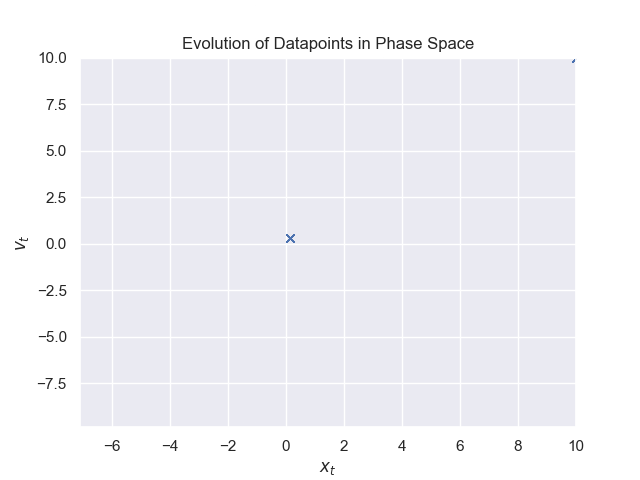

Text(0, 0.5, '$v_t$')

In [20]:
def f1(time = 0, num_samples = 1):
    return plot_arr.where(np.abs(plot_arr['t']- time)< 0.1).dropna(how='all')['xt'][:int(num_samples)]    
    
def f2(rand, time = 0, num_samples = 1):
    return plot_arr.where(np.abs(plot_arr['t']- time)< 0.1).dropna(how='all')['vt'][:int(num_samples)]


fig, ax = plt.subplots()
controls = iplt.plot(f1, f2, 'x', time=time, num_samples=(1,1000,100))
plt.show()


ax.set_title(r"Evolution of Datapoints in Phase Space")
ax.set_xlabel(r"$x_t$")
ax.set_ylabel(r"$v_t$")

In [21]:
#X, y, features, labels = generate(num_samples = int(1e3))
#arr,  features, labels = generate(num_samples = int(1e3))
X = plot_arr[features]
y = plot_arr[labels]
scaler = MinMaxScaler(feature_range=[0,1])
X_data = pd.DataFrame(scaler.fit_transform(X), columns=features)

In [22]:
def vals_to_df(values, data, save=False, explainer = "lime", suffix = None):
    xt_atts = values[0]
    vt_atts = values[1]
    data = data
    
    param_array = np.array(np.ones((data.shape[0], 5)))
    for i, param in enumerate(parameters):
        param_array[:,i] = parameters[param]*np.ones((data.shape[0]))

    df = pd.DataFrame(xt_atts, columns = ["xt_x0", "xt_v0", "xt_t", "xt_rand"])
    df = df.join(pd.DataFrame(vt_atts, columns = ["vt_x0", "vt_v0", "vt_t", "vt_rand"]))
    df = df.join(pd.DataFrame(data.values, columns = features))
    df = df.join(pd.DataFrame(param_array, columns = parameters.keys()))
    df.insert(1, 'explainer' ,[explainer for i in range(df.shape[0])])
    
    if save:
        df.to_csv("Results/"+explainer+"/"+explainer+"_vals_"+suffix+".csv")
    return df

## Define Background Samples to Compare to and Samples to Evaluate on

In [23]:
model = true_predict
background = shap.sample(X_data, 100)
feature = 'x0'
X_sorted = X_data.sort_values(by=[feature])
choice = X_sorted.iloc[np.sort(np.random.choice(X_sorted.shape[0], 100, replace =False))]

## Kernel SHAP

In [17]:
kernel_exp = shap.KernelExplainer(model, background)
kernel_shap_values = kernel_exp.shap_values(choice)
kernel_df = vals_to_df(kernel_shap_values, choice, save=False, explainer = "kernel", suffix = suffix)
big_df = kernel_df.copy()

  0%|          | 0/100 [00:00<?, ?it/s]

## Sampled SHAP

Looking at MCMC Shap for Confidence Intervals

In [18]:
sample_exp = shap.SamplingExplainer(model, X_sorted)
sample_shap_values = sample_exp.shap_values(choice)
sample_df = vals_to_df(sample_shap_values, choice, save=False, explainer = "sample", suffix = suffix)
big_df = big_df.append(sample_df)

  0%|          | 0/100 [00:00<?, ?it/s]

## LIME

In [19]:
class MyLime(shap.other.LimeTabular):
    def __init__(self, model, flipped_model, data, mode="classification"):
        self.model = model
        self.flipped = flipped_model
        assert mode in ["classification", "regression"]
        self.mode = mode

        if str(type(data)).endswith("pandas.core.frame.DataFrame'>"):
            data = data.values
        self.data = data
        self.explainer = lime.lime_tabular.LimeTabularExplainer(data, mode=mode)
        
        out = self.model(data[0:1])
        flipped_out = self.flipped(data[0:1])
        self.out_dim = self.model(data[0:1]).shape[1]
        self.flat_out = False
            
    def attributions(self, X, nsamples=5000, num_features=None):
        num_features = X.shape[1] if num_features is None else num_features
        
        if str(type(X)).endswith("pandas.core.frame.DataFrame'>"):
            X = X.values
            
        out = [np.zeros(X.shape) for j in range(self.out_dim+1)]
        for i in tqdm(range(X.shape[0]), desc="Generating Data…", ascii=False, ncols=75):
        #for i in range(X.shape[0]):
            for j in range(self.out_dim):
                exp1 = self.explainer.explain_instance(X[i], self.model, labels=range(self.out_dim), num_features=num_features, num_samples=500)
                exp2 = self.explainer.explain_instance(X[i], self.flipped, labels=range(self.out_dim), num_features=num_features, num_samples=500)
                for k, v in exp1.local_exp[1]:
                    #print("boo")
                    out[0][i,k] = v
                for k, v in exp2.local_exp[1]:
                    #print("boo")
                    out[1][i,k] = v
          
        return out
        

In [20]:
lime_exp = MyLime(true_lime_1, true_lime_2, choice, mode='regression')
lime_values = lime_exp.attributions(choice)
lime_df = vals_to_df(lime_values, choice, save=False, explainer = "lime", suffix = suffix)
big_df = big_df.append(lime_df)

Generating Data…: 100%|██████████████████| 100/100 [15:44<00:00,  9.45s/it]


## Exact Explainer

Currently not supported?

In [21]:
#exact_exp = shap.other.LimeTabular(model, background, mode='regression')

## Numerical Gradient Calculation

In [22]:
num_exp = NumericExplainer(model, features, labels, h = 0.001)
num_exp_values = num_exp.feature_att(choice)
num_df = vals_to_df(num_values, choice, save=True, explainer = "numerical", suffix = suffix)

NameError: name 'num_values' is not defined

In [ ]:
scaler_num = MinMaxScaler(feature_range=[-0.3,0.3])
scaled_num_exp_values = [scaler_num.fit_transform(num_exp_values[0]), scaler_num.fit_transform(num_exp_values[1])]

# Confidence Estimation

## Bootstrap

Here we use a bootstrap method to evaluate SHAP confidence intervals.

We want to see how confident SHAP is in the feature attributions for prediction y_i.

To do so:
    
    shap_vals = 0
    for i in range(num_loops):
        explainer = shap.KernelExplainer(model, background_i)
        shap_vals[i] = explainer.shap_values(x)
        shap_mean = shap_mean + shap_vals[i]/num_loops
    var = 0
    for i in range(num_loops):
        var = var + 1 * (shap_vals[i] - shap_mean)**2
    var = var * num_loops / ((num_loops - 1) * num_loops)

In [52]:
def bootstrap(X, background, model, num_straps = 50, back_size = 100, features = features, labels = labels):
    shap_vals = np.empty((num_straps, len(labels), len(features)))
    mean_std_arr = np.empty((2, len(labels), len(features)))
    for i in range(num_straps):
        background_i = shap.sample(background, back_size, random_state = np.random.randint(100))
        exp_i = shap.KernelExplainer(model, background_i)
        shapper = exp_i.shap_values(X)
        shap_vals[i,0,:] = shapper[0]
        shap_vals[i,1,:] = shapper[1]
    for i in range(len(labels)):
        for j in range(len(features)):
            mean_std_arr[0, i, j] = np.mean(shap_vals[:,i,j])
            mean_std_arr[1, i, j] = np.std(shap_vals[:,i,j])
            
    return mean_std_arr



num_strapped_samples = 50
x_list = X_data.iloc[np.sort(np.random.choice(X_sorted.shape[0], num_strapped_samples, replace =False))]
bootstrap_array = np.empty((num_strapped_samples, 2, len(labels), len(features)))
for i in range(x_list.shape[0]):
    x_val = x_list.iloc[i,:]
    bootstrap_array[i,:,:,:] = bootstrap(x_val, X_data, true_predict, num_straps = 100)
    
bootstrap_df = x_list.copy()
for k, col in enumerate(["mean", "std"]):
    for j in range(len(labels)):
        for i in range(len(features)):
            bootstrap_df.insert(4 + i + j*len(features) + k*len(features)*len(labels), features[i] + "_" + labels[j] + "_" + col, bootstrap_array[:,k,j,i])
        
explainer = "Kernel"
bootstrap_df.to_csv("Results/"+explainer+"/"+explainer+"bootstrap_vals_"+suffix+".csv")

In [55]:
class Bootstrapper():
    def __init__(model, data, explainer_type = 'kernel', num_straps = 50, back_size = 100, 
                 features = features, labels = labels, lime_models = [true_lime_1, true_lime_2], suffix = suffix)
        self.explainer_type = explainer_type
        self.model = model
        self.data = data
        self.features = features
        self.labels = labels
        self.num_straps = num_straps
        self.back_size = back_size
        self.suffix = suffix
        
    def bootstrap(self, X):
        self.values = np.empty((self.num_straps, len(self.labels), len(self.features)))
        self.mean_std_arr = np.empty((2, len(self.labels), len(self.features)))
        for i in range(self.num_straps):
            background_i = shap.sample(self.data, self.back_size, random_state = np.random.randint(100))
            if self.explainer_type == 'kernel':
                exp_i = shap.KernelExplainer(self.model, background_i)
                shapper = exp_i.shap_values(X)
            elif self.explainer_type == 'sample':
                exp_i = shap.SampleExplainer(self.model, background_i)
                shapper = exp_i.shap_values(X)
            else self.explainer_type == 'lime':
                exp_i = MyLime(self.lime_models[0], self.lime_models[1], background_i, mode='regression')
                shapper = exp_i.attributions(X)
            self.values[i,0,:] = shapper[0]
            self.values[i,1,:] = shapper[1]
        for i in range(len(labels)):
            for j in range(len(features)):
                self.mean_std_arr[0, i, j] = np.mean(self.values[:,i,j])
                self.mean_std_arr[1, i, j] = np.std(self.values[:,i,j])
            
    return self.mean_std_arr
    
    def to_df(self):
        self.bootstrap_df = self.x_list.copy()
        for k, col in enumerate(["mean", "std"]):
            for j in range(len(self.labels)):
                for i in range(len(self.features)):
                    self.bootstrap_df.insert(4 + i + j*len(self.features) + k*len(self.features)*len(self.labels), 
                                             self.features[i] + "_" + self.labels[j] + "_" + col, 
                                             self.bootstrap_array[:,k,j,i])
        if self.save:
            self.bootstrap_df.to_csv("Results/"+self.explainer_type+"/"+self.explainer_type+"bootstrap_vals_"+self.suffix+".csv")
        return self.bootstrap_df
    def calculate(self, num_samples = 50, save = True):
        self.x_list = self.data.iloc[np.sort(np.random.choice(self.data.shape[0], num_samples, replace =False))]
        self.bootstrap_array = np.empty((num_strapped_samples, 2, len(labels), len(features)))
        for i in range(x_list.shape[0]):
            x_val = self.x_list.iloc[i,:]
            self.bootstrap_array[i,:,:,:] = self.bootstrap(x_val)
        return self.to_df()


In [ ]:
bootstrapper = Bootstrapper(model, X_data)
bootstrapper.calculate()

<IPython.core.display.Javascript object>


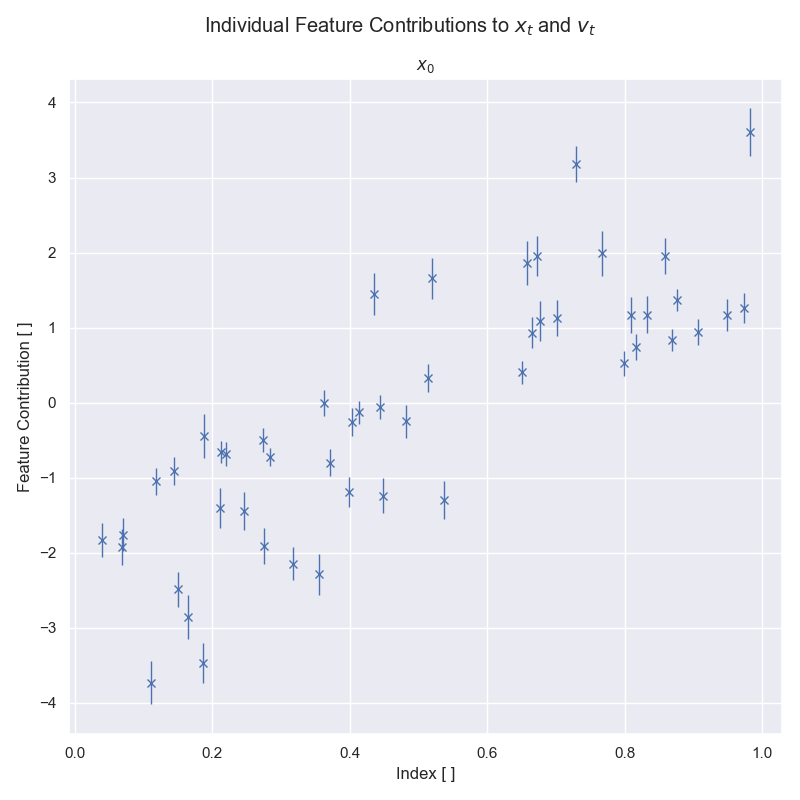

In [58]:
# Individual Feature Contributions
f, axs = plt.subplots(1, 1, figsize = (8,8), gridspec_kw = dict(width_ratios = [4]))

#sns.scatterplot(x='x0', y="xt_x0", data=bootstrap_array, ax=axs[0,0], marker = 'x', linewidth = 1, hue = "explainer")


axs.errorbar(x_list['x0'] ,bootstrap_array[:,0,0,0], yerr=bootstrap_array[:,1,0,0], fmt = 'x', linewidth=1) #yerr = bootstrap_array[:,1])

axs.set_title(r"$x_0$")
axs.set_xlabel('Index [ ]')
axs.set_ylabel('Feature Contribution [ ]')



f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$")

f.tight_layout()
#f.savefig("Images/feature_contributions_sorted_by_feature_"+suffix+".svg", dpi='figure')


In [ ]:
num_loops = 50
shap_vals = np.empty((num_loops,len(features), len(labels)))

# instance to be explained
x = X_sorted.iloc[np.sort(np.random.choice(X_sorted.shape[0], 1, replace =False))]

for i in range(num_loops):
    background_i = shap.sample(X_data, 100)
    explainer = shap.KernelExplainer(model, background_i)
    shap_vals[i,:,:] = explainer.shap_values(x)
    shap_mean = shap_mean + shap_vals[i,:,:]/num_loops

var = np.std(shap_vals)

#    var = 0
#for i in range(num_loops):
#    var = var + 1 * (shap_vals[i,:,:] - shap_mean)**2
#var = var * num_loops / ((num_loops - 1) * num_loops)

In [ ]:
def bs_cis(data, explainer, target_confidence=0.1):
    while confidence < target_confidence:
        X_sorted = X_data.sort_values(by=[feature])
        choice = X_sorted.iloc[np.sort(np.random.choice(X_sorted.shape[0], 100, replace =False))]
        curr_vals = explainer.shap_values(choice)
        agg_curr_vals = aggregate(curr_vals)
        

## Random Sampling
 
 #### Hoeffding's Inequality
 
 From this we use:
 
 $P(|\bar{X} - E[\bar{X}]| \geq t) \leq 2e^{-2nt^2}$

 From this follows that the number of samples needed to ensure a $(1-\alpha)$ confidence interval around $E[\bar{X}]$ of width $2t$ is: $\frac{log(2/\alpha)}{2t^2}$
 
 
 mean and variance updating from:
 https://dl.acm.org/doi/pdf/10.1145/359146.359153

In [ ]:
conf_int = 0.05 # 95% confidence interval
int_width = 0.1 # half width of interval (t)
conf_n = int(np.log(2/conf_int)/(2*int_width**2))
conf_n = 3
conf_vals_arr = np.empty((conf_n, len(features), len(labels)))

conf_instance = X_data.iloc[np.random.choice(X_data.shape[0], 1, replace =False)]

temp_vals_conf = kernel_exp.shap_values(conf_instance)
for j in range(len(labels)):
    conf_vals_arr[0,:,j] = temp_vals_conf[j]
        


m_conf = conf_vals_arr[0,:,:]

sumw = np.ones_like(m_conf)

t_conf = 0

for i in range(1, conf_n):
    conf_instance = X_data.iloc[np.random.choice(X_data.shape[0], 1, replace =False)]
    print(i)
    temp_vals_conf = kernel_exp.shap_values(conf_instance)
    for j in range(len(labels)):
        conf_vals_arr[i,:,j] = temp_vals_conf[j]
        
    q_conf = conf_vals_arr[i,:,:] - m_conf
    temp_sum = sumw + np.ones_like(m_conf)
    r_conf = np.multiply(q_conf, np.divide(np.ones_like(temp_sum), temp_sum))
    #r_conf = q_conf * 1/temp_sum
    m_conf = m_conf + r_conf
    t_conf = t_conf + r_conf * sumw * q_conf
    sumw = temp_sum
    
x_bar = m_conf
var = t_conf * conf_n/((conf_n - 1) * sumw)

In [ ]:
# save dataframes
big_df.to_csv("Results/big_dataframe"+suffix+".csv")

# Plotting

<IPython.core.display.Javascript object>


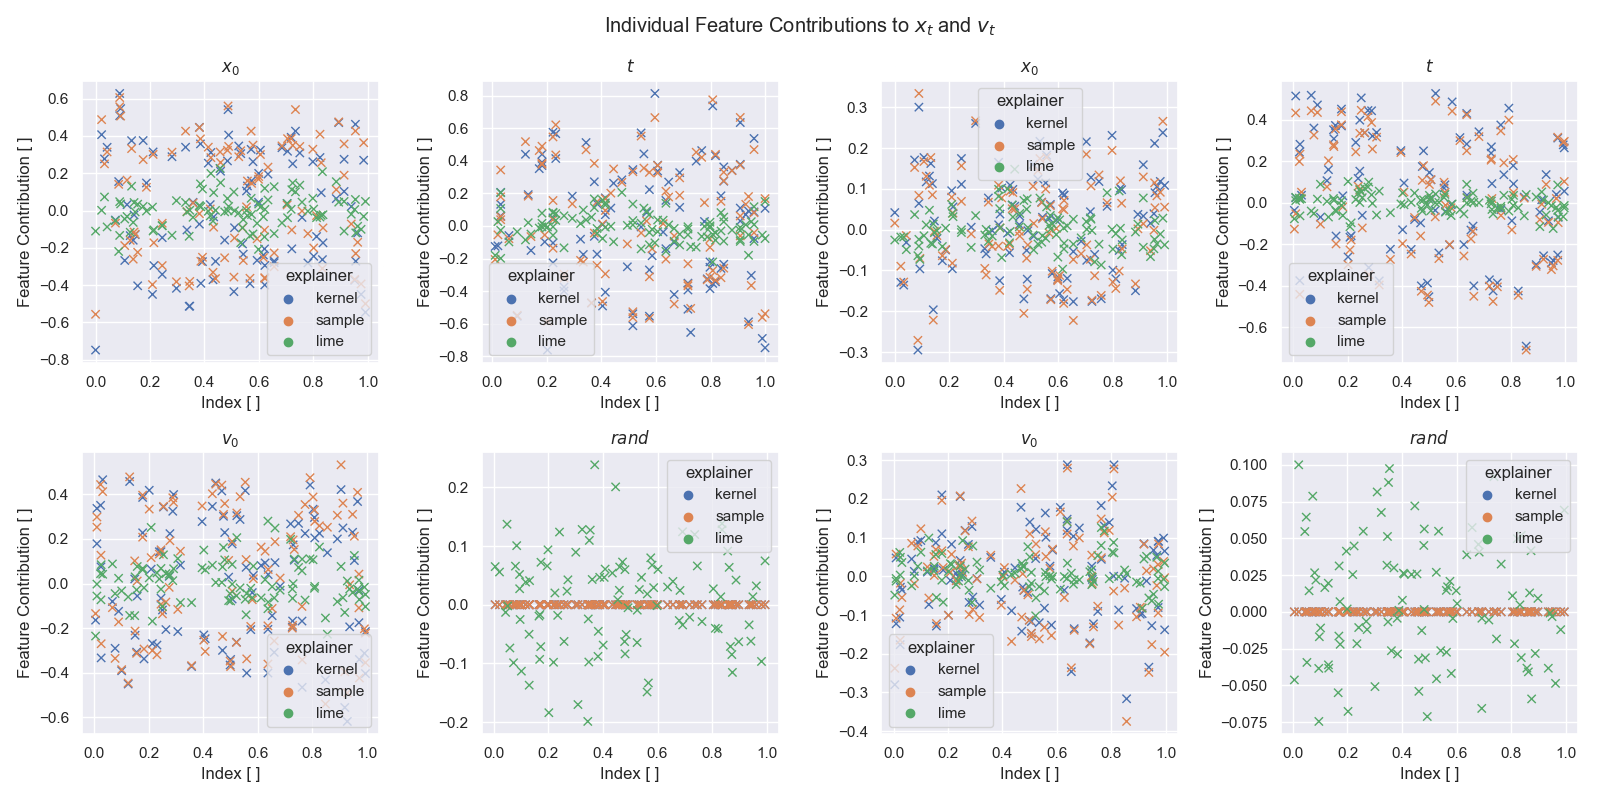

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of 

In [23]:
# Individual Feature Contributions
f, axs = plt.subplots(2, 4, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4,4,4]))

sns.scatterplot(x='x0', y="xt_x0", data=big_df, ax=axs[0,0], marker = 'x', linewidth = 1, hue = "explainer")

axs[0,0].set_title(r"$x_0$")
axs[0,0].set_xlabel('Index [ ]')
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="xt_v0", data=big_df, ax=axs[1,0], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,0].set_title(r"$v_0$")
axs[1,0].set_xlabel('Index [ ]')
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='t', y="xt_t", data=big_df, ax=axs[0,1], marker = 'x', linewidth = 1, hue = "explainer")
axs[0,1].set_title(r"$t$")
axs[0,1].set_xlabel('Index [ ]')
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='rand', y="xt_rand", data=big_df, ax=axs[1,1], marker = 'x', linewidth = 1, hue = "explainer")

axs[1,1].set_title(r"$rand$")
axs[1,1].set_xlabel('Index [ ]')
axs[1,1].set_ylabel('Feature Contribution [ ]')


sns.scatterplot(x='x0', y="vt_x0", data=big_df, ax=axs[0,2], marker = 'x', linewidth = 1, hue = "explainer")

axs[0,2].set_title(r"$x_0$")
axs[0,2].set_xlabel('Index [ ]')
axs[0,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="vt_v0", data=big_df, ax=axs[1,2], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,2].set_title(r"$v_0$")
axs[1,2].set_xlabel('Index [ ]')
axs[1,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="vt_t", data=big_df, ax=axs[0,3], marker = 'x', linewidth = 1, hue = "explainer")
axs[0,3].set_title(r"$t$")
axs[0,3].set_xlabel('Index [ ]')
axs[0,3].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='rand', y="vt_rand", data=big_df, ax=axs[1,3], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,3].set_title(r"$rand$")
axs[1,3].set_xlabel('Index [ ]')
axs[1,3].set_ylabel('Feature Contribution [ ]')



f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$")

f.tight_layout()
f.savefig("Images/feature_contributions_sorted_by_feature_"+suffix+".svg", dpi='figure')


In [24]:
# Convert Data to Long Form to enable plotting with sns barplot

plot_cols = ['xt_x0', 'xt_v0', 'xt_t', 'xt_rand', 'vt_x0', 'vt_v0', 'vt_t', 'vt_rand', 'explainer']
agg_df = big_df[plot_cols].copy().set_index('explainer')
temp_df = pd.DataFrame()
agg_df_2 = pd.DataFrame()
for j, col in enumerate(agg_df.columns[:8]):
    for expl in agg_df.index.unique():
        temp_df['value'] = agg_df.loc[expl][col].values
        temp_df['feature'] = col
        temp_df['explainer'] = expl
        agg_df_2 = agg_df_2.append(temp_df)

<IPython.core.display.Javascript object>


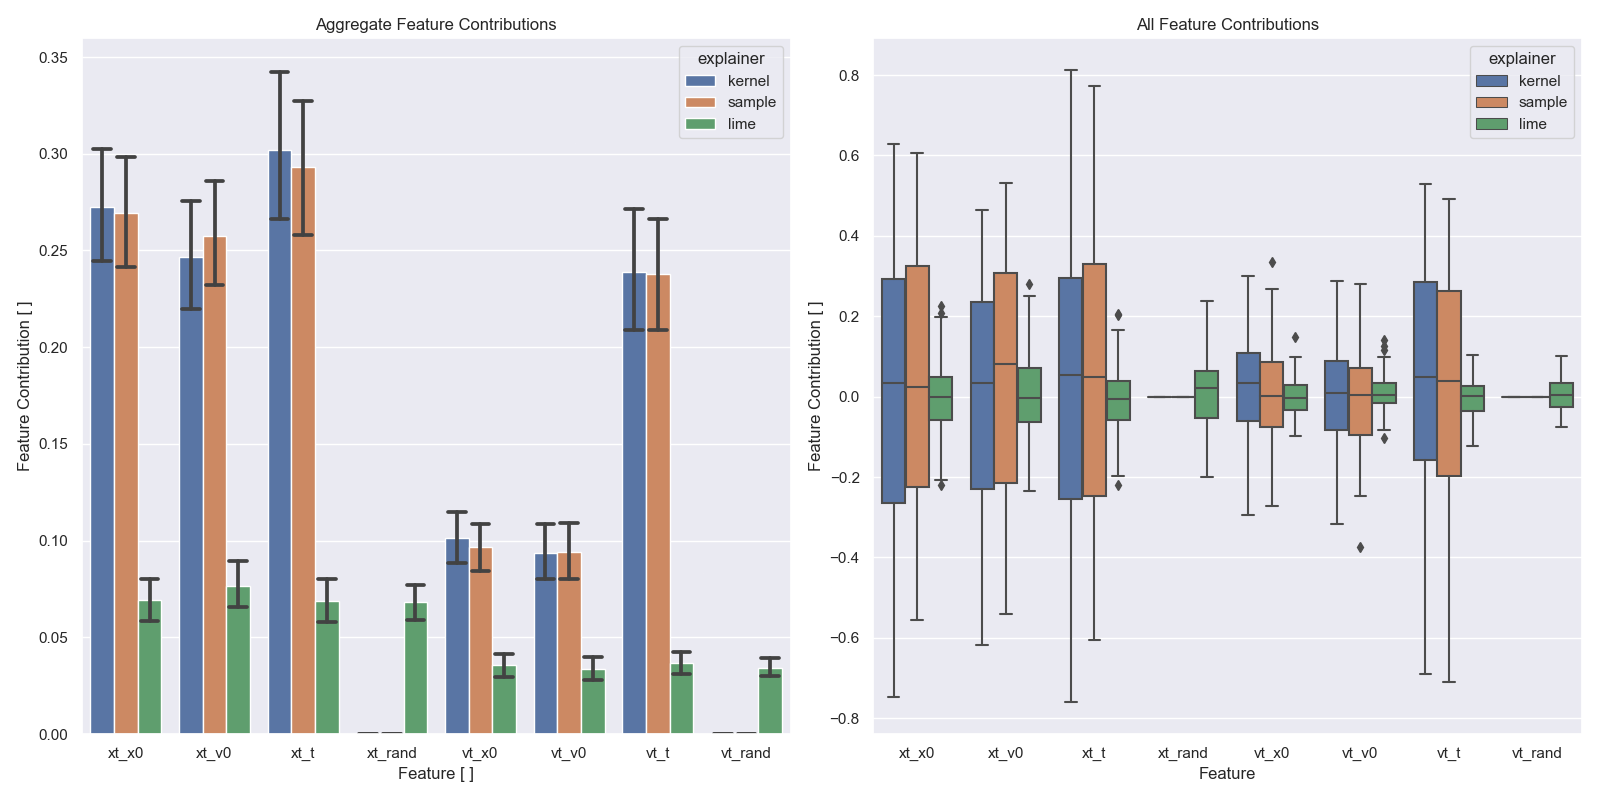

In [32]:
# Aggregated

f, axs = plt.subplots(1, 2, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4]))


sns.barplot(data=agg_df_2, x = 'feature', y = np.abs(agg_df_2['value']), hue = 'explainer', ax = axs[0], ci = 95, capsize=.2)

axs[0].set_title(r"Aggregate Feature Contributions")
axs[0].set_xlabel('Feature [ ]')
axs[0].set_ylabel('Feature Contribution [ ]')

sns.boxplot(data=agg_df_2, x = 'feature', y = 'value', ax = axs[1], hue = 'explainer')
axs[1].set_title(r"All Feature Contributions")
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Feature Contribution [ ]')


f.tight_layout()

f.savefig("Images/all_aggregated_"+suffix+".svg", dpi='figure')

<IPython.core.display.Javascript object>


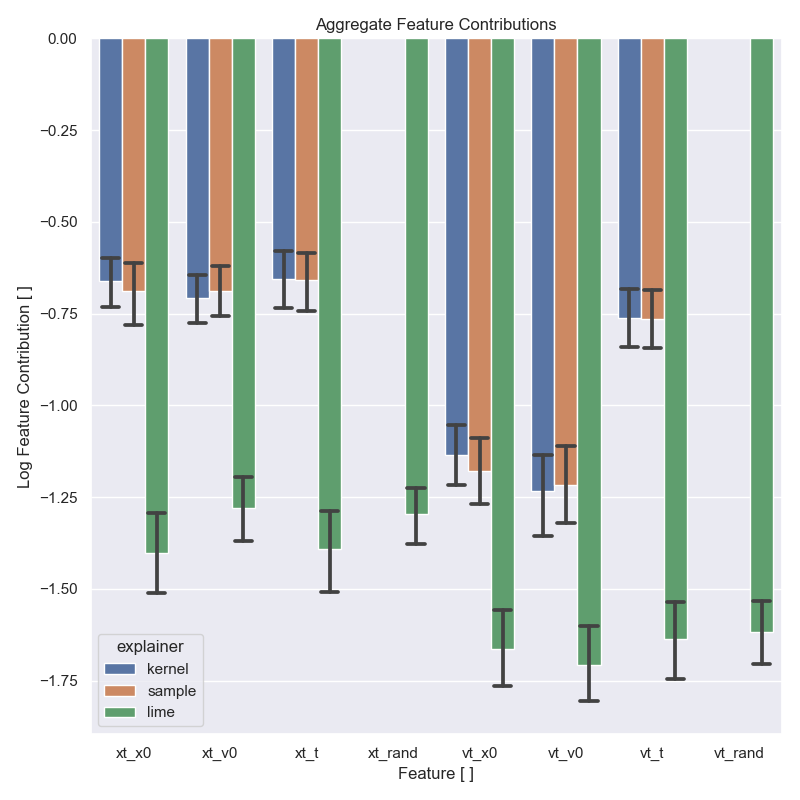

divide by zero encountered in log10
invalid value encountered in subtract


In [33]:
# Aggregated

f, axs = plt.subplots(1, 1, figsize = (8,8), gridspec_kw = dict(width_ratios = [4]))


sns.barplot(data=agg_df_2, x = 'feature', y = np.log10(np.abs(agg_df_2['value'])), hue = 'explainer', ax = axs, ci = 95, capsize=.2)

axs.set_title(r"Aggregate Feature Contributions")
axs.set_xlabel('Feature [ ]')
axs.set_ylabel('Log Feature Contribution [ ]')




f.tight_layout()

f.savefig("Images/all_aggregated_"+suffix+"_log.svg", dpi='figure')